# Introduction

This is my second post using Framingham's cardiovascular study. In this post I will use this data set to introduce feature engineering and ensemble modeling. Firstly, I will display some feature analyses then ill focus on the feature engineering. Last part concerns modeling and predicting the 10-year risk of coronary heart disease.

The attributes are classified into several categories:

Demographic:
Sex: male or female (Nominal)
Age: Age of the patient (Continuous, though recorded in whole numbers)

Behavioral:
Current Smoker: Indicates if the patient is currently a smoker (Nominal)
Cigs Per Day: Average number of cigarettes smoked per day (Continuous, as it can take any numerical value)

Medical history:
BP Meds: Indicates if the patient was using blood pressure medication (Nominal)
Prevalent Stroke: Indicates if the patient had previously experienced a stroke (Nominal)
Prevalent Hyp: Indicates if the patient was hypertensive (Nominal)
Diabetes: Indicates if the patient had diabetes (Nominal)

Medical:
Tot Chol: Total cholesterol level (Continuous)
Sys BP: Systolic blood pressure (Continuous)
Dia BP: Diastolic blood pressure (Continuous)
BMI: Body Mass Index (Continuous)
Heart Rate: Heart rate (Continuous)
Glucose: Glucose level (Continuous)

Predicted Variable:
10-year risk of coronary heart disease CHD (binary: “1” signifies “Yes”, “0” signifies “No”)


This script follows three main parts:

Feature analysis
Feature engineering
Modeling



### References

https://www.kaggle.com/code/leaphys/titanic-top-4-with-ensemble-modeling

https://github.com/vahadruya/Capstone_Classification_Cardiovascular_Risk_Prediction/blob/main/Trial%20Notebooks/Classification_ML_Capstone_CVD_Risk_Prediction_KNNImputer.ipynb

#### Import libraries

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, make_scorer, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG, display

import xgboost as xgb





sns.set(style='white', context='notebook', palette='deep')

### Load and check data

#### Load data

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Replace with the path to your CSV file
csv_path = '/content/drive/MyDrive/Colab Notebooks/framingham.csv'

# Read CSV file into a DataFrame
df = pd.read_csv(csv_path)

#### Outlier detection

Outlier is a data point that differs significantly from other observations. An outlier may be due to a variability in the measurement, an indication of novel data, or it may be the result of experimental error.

In this case we use Tukey method (Tukey JW., 1977) to detect outliers. This method establishes an interquartile range (IQR) between the 1st and 3rd quartiles of the distribution values. An outlier is identified as a row with a feature value beyond the (IQR ± an outlier step).

In [4]:
# Outlier detection

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare

Outliers_more_than_0 = detect_outliers(df,0,['age','cigsPerDay','totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose'])

Outliers_more_than_1 = detect_outliers(df,1,['age','cigsPerDay','totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose'])

Outliers_more_than_2 = detect_outliers(df,2,['age','cigsPerDay','totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose'])





In [5]:
df.loc[Outliers_more_than_0] # Show the outliers rows

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
44,0,53,3.0,0,0.0,1.0,0,1,1,311.0,206.0,92.0,21.51,76.0,215.0,1
66,0,62,1.0,0,0.0,0.0,0,1,1,212.0,190.0,99.0,29.64,100.0,202.0,0
87,0,61,2.0,1,1.0,0.0,0,1,0,326.0,200.0,104.0,38.46,57.0,78.0,0
108,0,66,1.0,0,0.0,0.0,0,1,0,278.0,187.0,88.0,40.52,90.0,84.0,1
153,0,66,1.0,0,0.0,0.0,0,1,0,214.0,212.0,104.0,25.32,57.0,84.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,1,68,1.0,1,15.0,0.0,0,0,0,157.0,106.0,48.0,26.73,65.0,65.0,1
3709,0,46,1.0,1,20.0,0.0,0,1,0,275.0,170.0,118.0,36.12,82.0,84.0,0
3745,0,61,1.0,0,0.0,0.0,0,1,0,240.0,163.0,112.5,26.80,75.0,82.0,0
3819,0,53,2.0,0,0.0,0.0,0,1,0,230.0,170.0,113.0,29.55,115.0,115.0,0


In [6]:
df.loc[Outliers_more_than_1] # Show the outliers rows

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
158,0,49,3.0,0,0.0,1.0,0,1,0,254.0,191.0,124.5,28.35,78.0,54.0,0
249,0,60,1.0,1,20.0,0.0,0,0,1,180.0,200.0,122.5,44.27,88.0,150.0,0
407,0,46,2.0,0,0.0,0.0,0,1,0,184.0,188.0,123.0,34.36,90.0,NaN,0
414,0,55,2.0,1,3.0,0.0,0,1,0,323.0,197.0,118.0,27.51,80.0,112.0,0
446,1,61,1.0,0,0.0,0.0,0,1,0,182.0,209.0,133.0,30.77,65.0,75.0,0
481,0,64,1.0,0,0.0,0.0,0,1,0,253.0,295.0,135.0,38.82,92.0,70.0,1
531,0,61,1.0,0,0.0,0.0,0,1,0,217.0,189.0,121.0,37.41,85.0,100.0,0
588,0,52,1.0,1,3.0,0.0,0,1,0,210.0,185.0,114.0,27.01,70.0,83.0,0
590,0,60,2.0,1,20.0,1.0,0,1,0,294.0,220.0,118.0,24.22,90.0,59.0,0
797,0,59,4.0,0,0.0,NaN,0,1,0,240.0,195.0,118.0,23.82,80.0,73.0,0


In [7]:
df.loc[Outliers_more_than_2] # Show the outliers rows

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD


There are 162 rows with at least one outlier, 45 rows with two outliers and 0 rows with more than 2 outliers.
Because this is a medical reseach, outliers could be extreme because of unusual physiological conditions. In this case, We will keep outliers in order to preserve the complete spectrum.

#### Check for null and missing values

In [8]:
# Fill empty and NaNs values with NaN
df = df.fillna(np.nan)

# Check for Null values
df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [9]:
# Calculate the percentage of missing values for each column
percentage_missing = (df.isnull().sum() / df.shape[0]) * 100
print(percentage_missing)

male               0.000000
age                0.000000
education          2.477584
currentSmoker      0.000000
cigsPerDay         0.684285
BPMeds             1.250590
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            1.179802
sysBP              0.000000
diaBP              0.000000
BMI                0.448325
heartRate          0.023596
glucose            9.155262
TenYearCHD         0.000000
dtype: float64


Education and Glucose are the primary features with missing values, accounting for 2% and 9% of missing data, respectively. We will address the handling of these missing values in the Feature Engineering section.

In [10]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


### Feature analysis

#### Numerical values

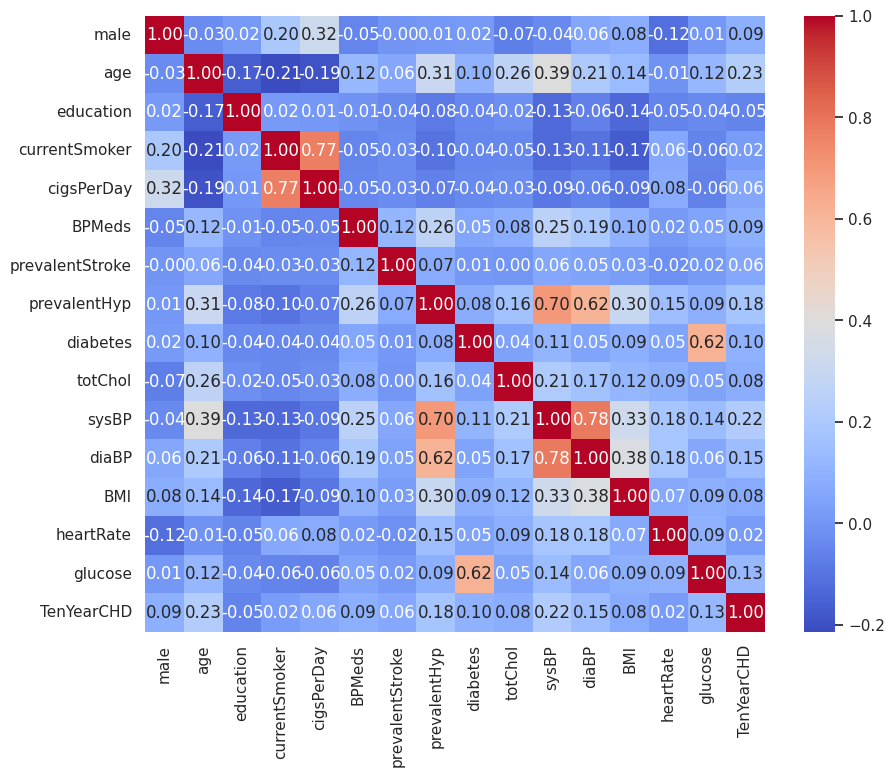

In [11]:
# Correlation matrix between feature values and TenYearCHD
plt.figure(figsize=(10, 8))  # Adjust the values (width, height) as needed

# Generate the heatmap
g = sns.heatmap(df[df.columns].corr(), annot=True, fmt=".2f", cmap="coolwarm")

# Display the heatmap
plt.show()

We observe a correlation between the blood pressure columns "sysBP" and "diaBP", along with a correlation with the "prevalentHyp" column for individuals who were previously hypertensive. Additionally, as expected, "diabetes" correlates with "glucose." However, none of these variables exhibit a significant correlation with the "TenYearCHD" column.

#### Categorical variables

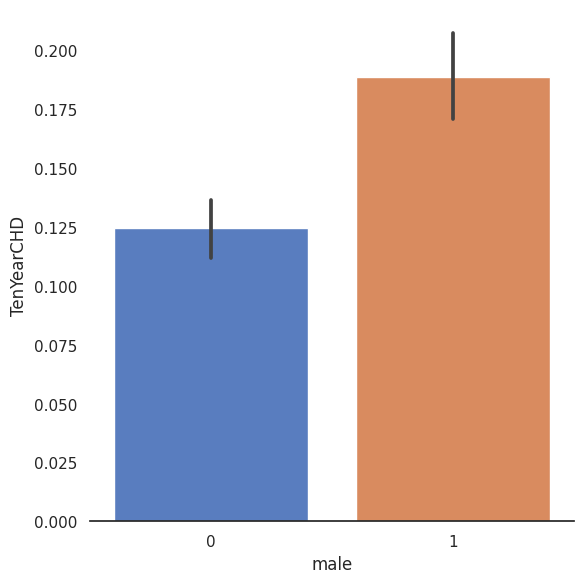

In [12]:
# Explore sex feature vs TenYearCHD
g = sns.catplot(x="male",y="TenYearCHD",data=df,kind="bar" , height=6,
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("TenYearCHD")

In [13]:
df[["male","TenYearCHD"]].groupby('male').mean()

,TenYearCHD
male,
0,0.124432
1,0.188565


Men are more likely to have the desise.

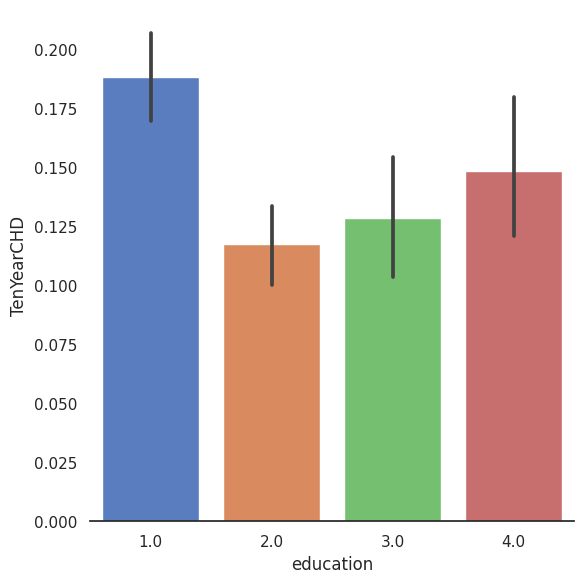

In [14]:
# Explore education feature vs TenYearCHD
g = sns.catplot(x="education",y="TenYearCHD",data=df,kind="bar" , height=6,
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("TenYearCHD")


It seems that education has not a big impact on risk of coronary heart disease. Something interesting to observe is that people with no education has more chance to have heart disease.

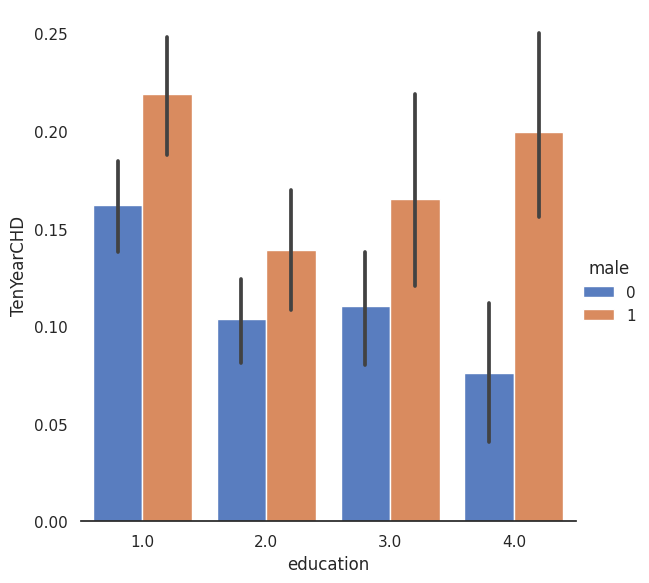

In [15]:
# Explore Education vs TenYearsCHD by Sex
g = sns.catplot(x="education", y="TenYearCHD", hue="male", data=df,
                   height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("TenYearCHD")

Patient risck are not the same in the 4 education categories. Men are always more likely to have CHD. There is a big difference between highly educated women and men. Women in this group are the least likely to have a CHD while men are just as likely as men with low education.

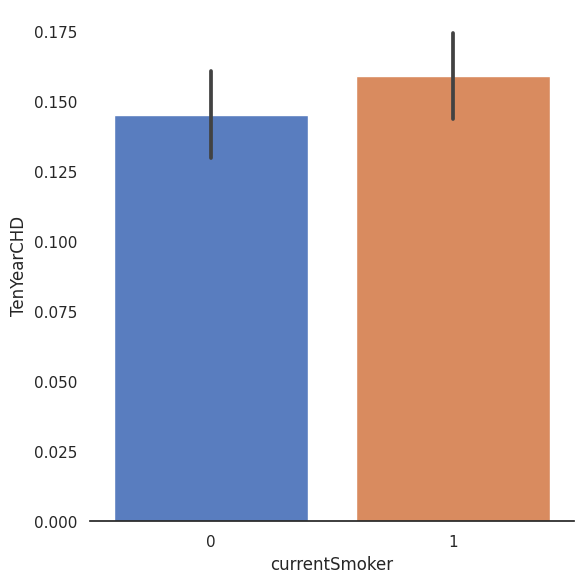

In [16]:
# Explore smoker feature vs TenYearCHD
g = sns.catplot(x="currentSmoker",y="TenYearCHD",data=df,kind="bar" , height=6,
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("TenYearCHD")

Contrary to expectations, smokers and non-smokers do not show a large difference in risk

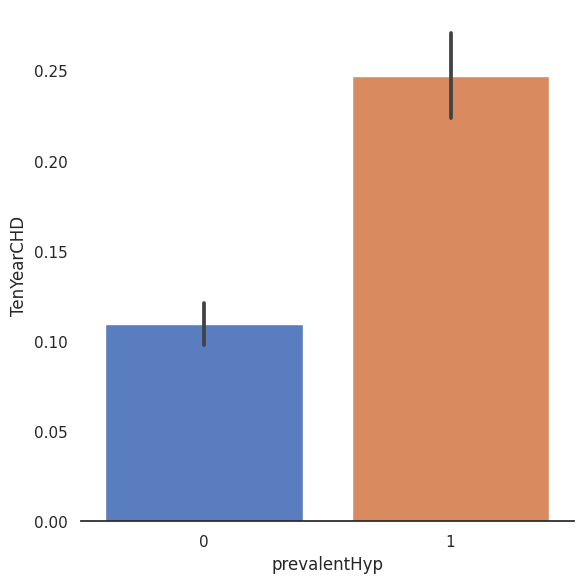

In [17]:
# Explore prevalentHyp feature vs TenYearCHD
g = sns.catplot(x="prevalentHyp",y="TenYearCHD",data=df,kind="bar" , height=6,
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("TenYearCHD")

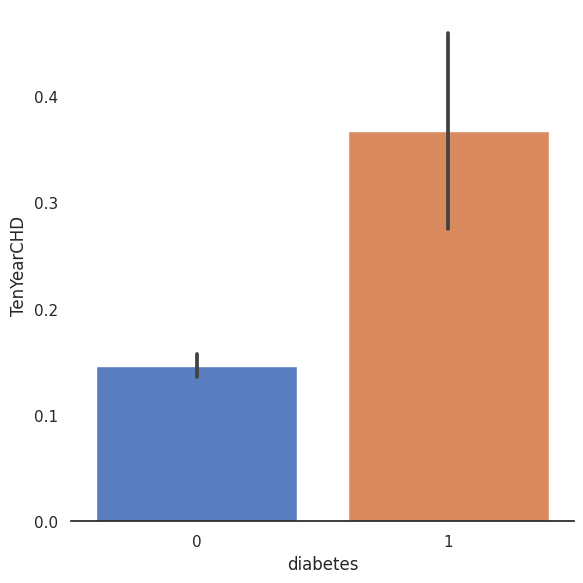

In [18]:
# Explore diabetes feature vs TenYearCHD
g = sns.catplot(x="diabetes",y="TenYearCHD",data=df,kind="bar" , height=6,
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("TenYearCHD")

Clinical hystory like prevalent hypertensive or diabetes has more chances to have CHD.  

!! this observation is quite interesting, we can consider a new feature describing these categories.

#### Numerical variables

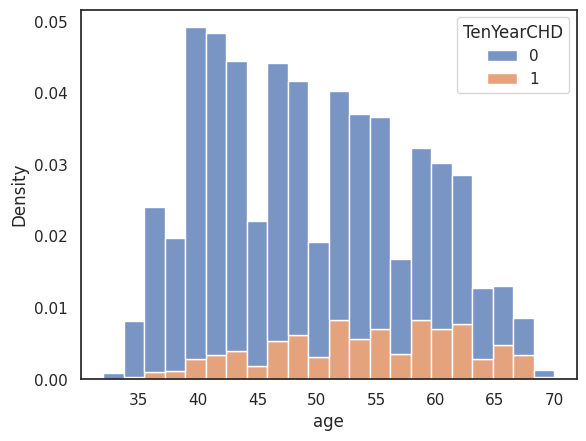

In [19]:
# Explore Age vs TenYearCHD
# Assuming 'TenYearCHD' is a categorical variable
g = sns.histplot(data=df, x='age', hue='TenYearCHD', multiple='stack', stat='density')

We notice that the age distribution are not the same in the two populations. Negative CHD has a peack corresponding with 40-45 yearsold patients. This may be because it is the youngest age to start doing heart checks. The majority of patients who undergo studies are healthy. As age advances, the chances of having CHD increase. The positive CHD does not present a clear peack. The largest number of cases are found between the ages of 52 - 62.


So, even if "age" is not correlated with 'TenYearCHD'we can see that there is age categories of patients that have more chances to be healthy. Younger patients have more chances to be CHD negative.

<ipython-input-20-eb554c616992>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(df["cigsPerDay"], color="m", label="Skewness : %.2f"%(df["cigsPerDay"].skew()))


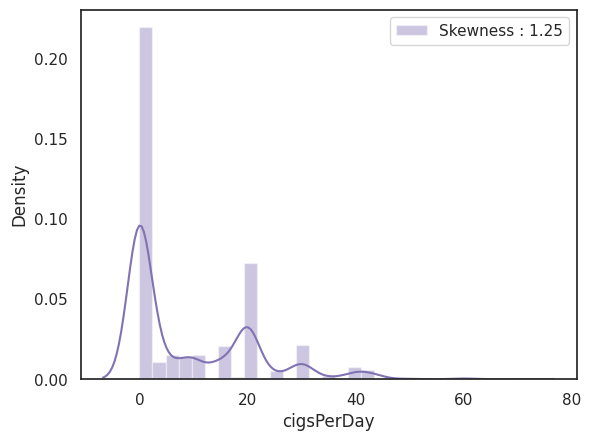

In [20]:
# Explore Fare distribution
g = sns.distplot(df["cigsPerDay"], color="m", label="Skewness : %.2f"%(df["cigsPerDay"].skew()))
g = g.legend(loc="best")

The number of cigarettes per day appears highly skewed, potentially causing overweighted influence by high values in the model.

Let's conduct a skewness analysis for the continuous features within the dataset

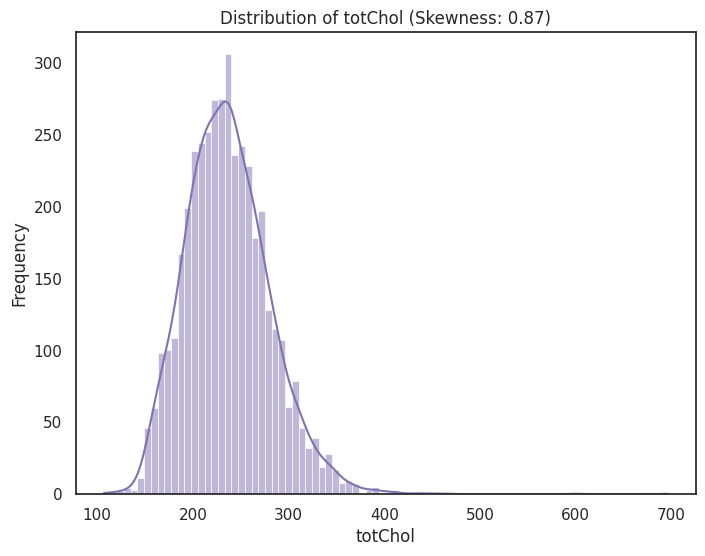

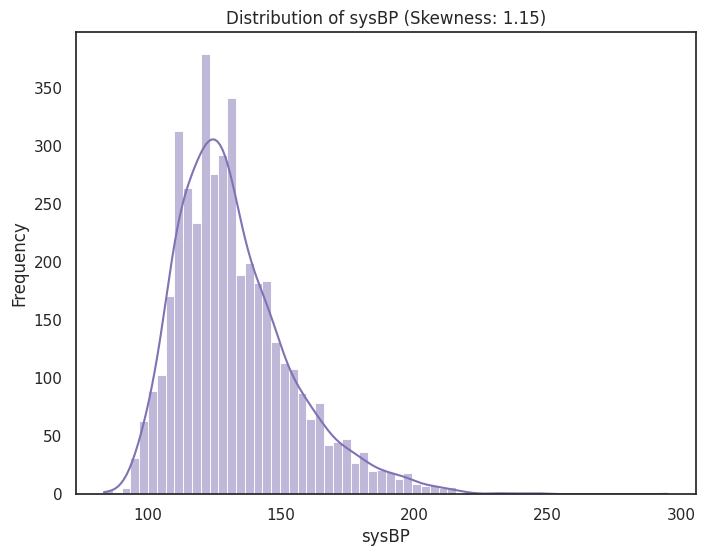

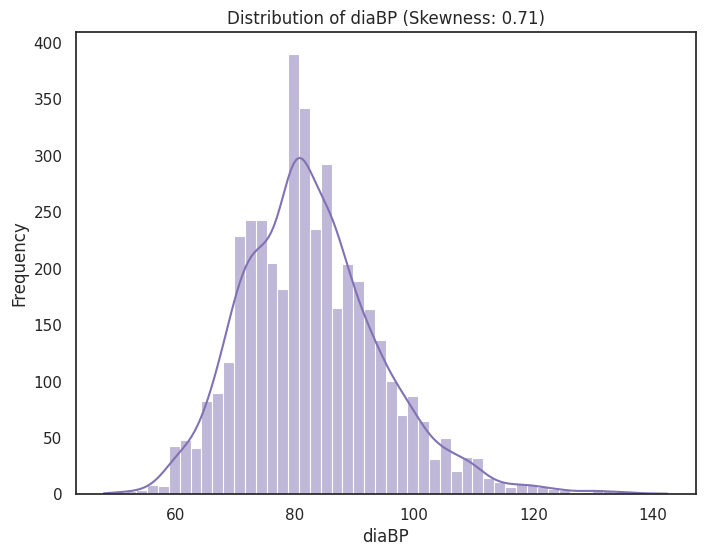

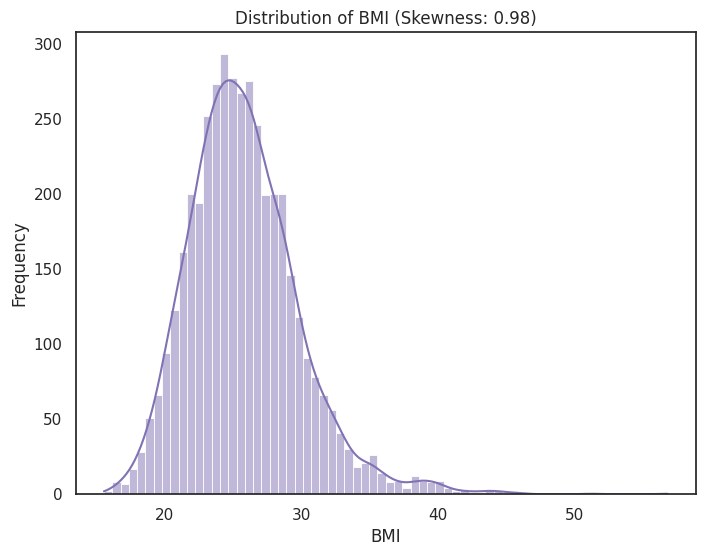

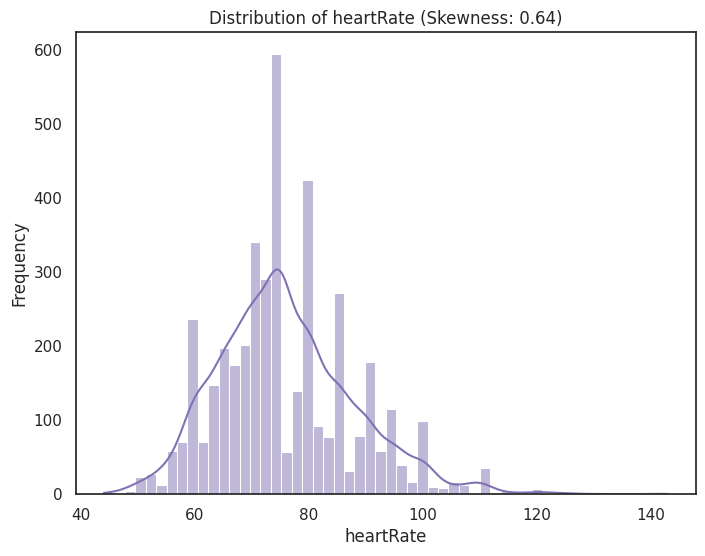

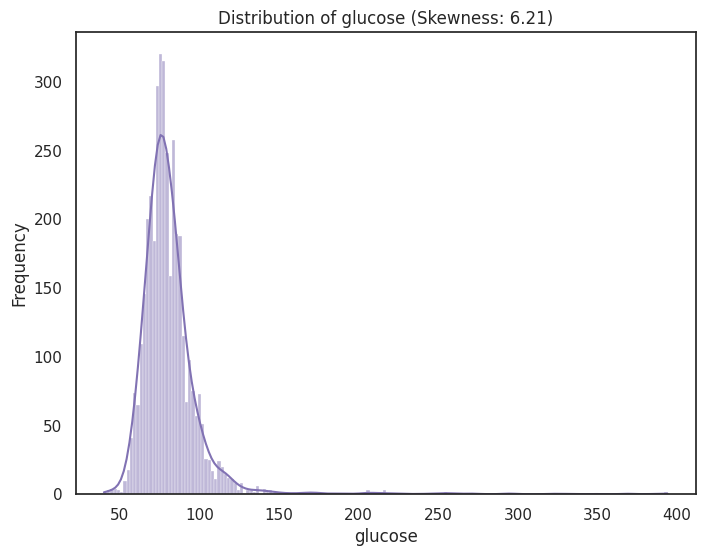

In [111]:
# List of columns you want to explore
columns_to_explore = ['totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']  # Add other column names as needed

# Loop through each column and create a distribution plot
for col in columns_to_explore:
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    sns.histplot(data=df, x=col, color="m", kde=True)
    skewness = df[col].skew()
    plt.title(f"Distribution of {col} (Skewness: {skewness:.2f})")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

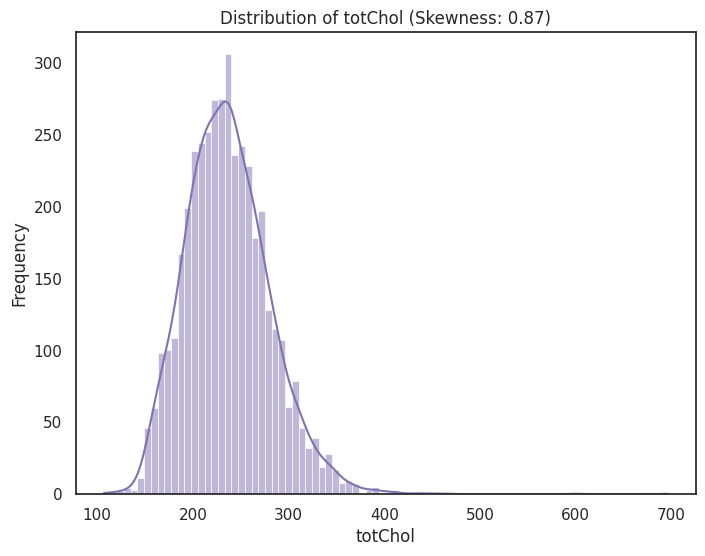

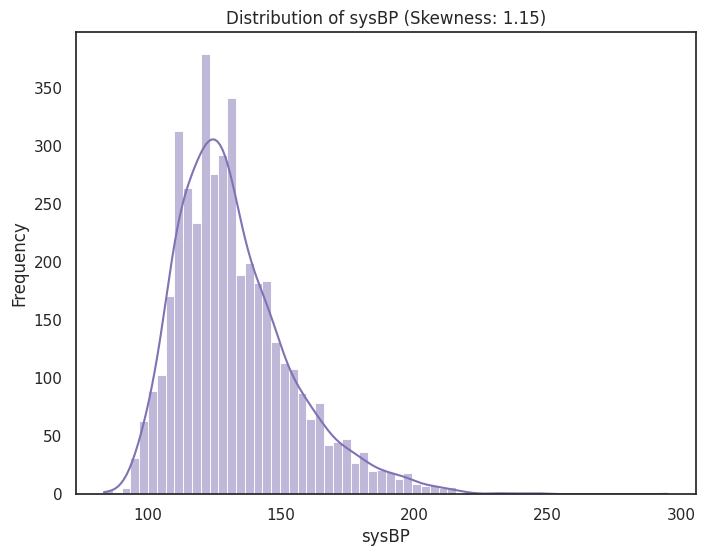

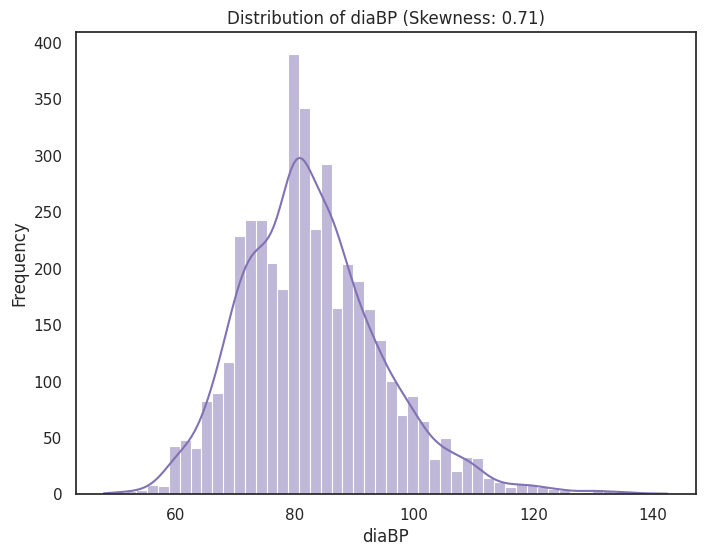

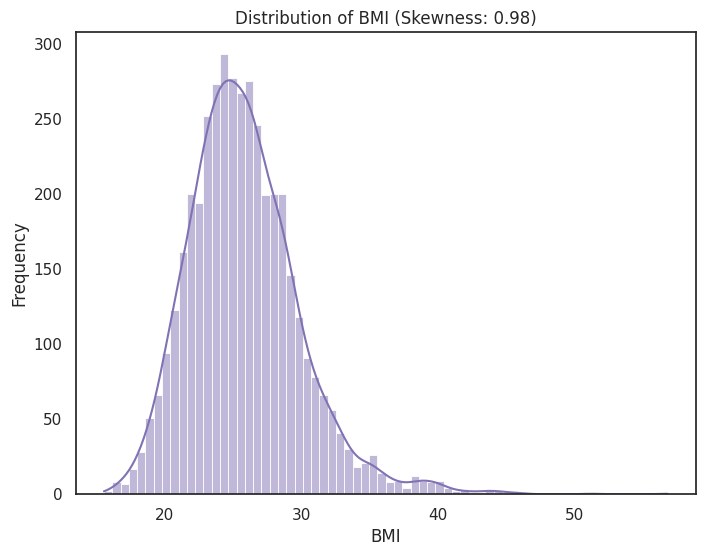

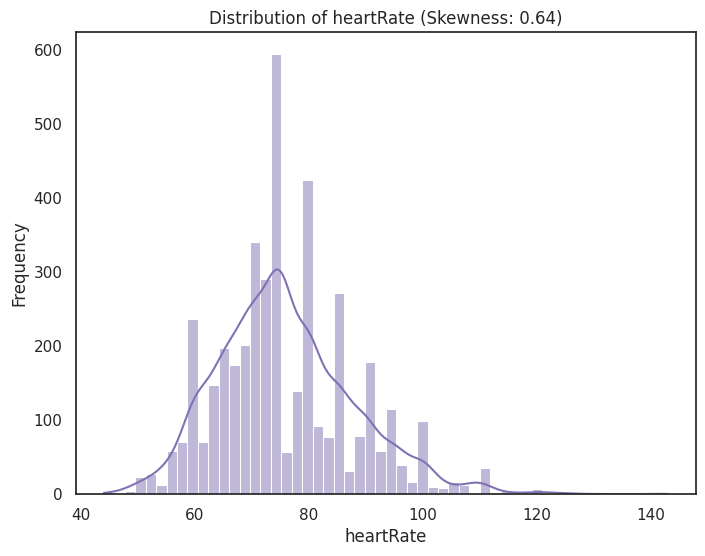

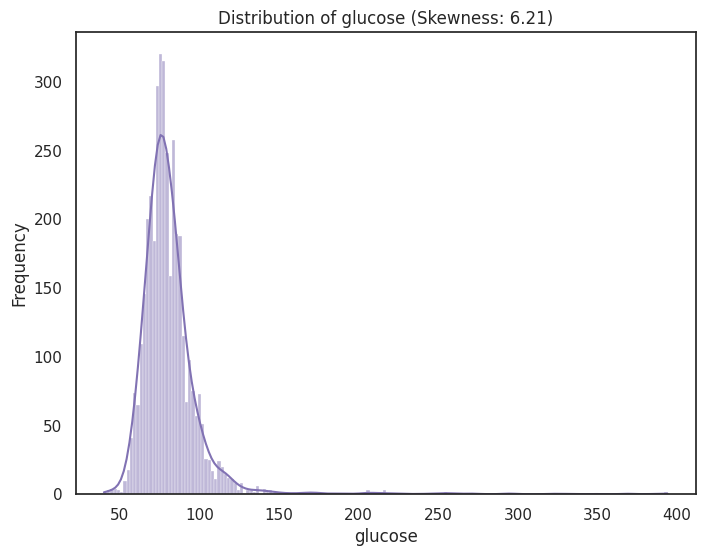

As we can see, glucose distribution is very skewed. This is something to keep in mindbecause can impact on model performance.

### Feature engineering

### Missing values

Education missing values

In [21]:
# Education missing values will be filled with the lowest level of education
df['education'].fillna(1.0, inplace=True)

Patients using blood pressure medication

In [22]:
bpmeds_missing = df[df['BPMeds'].isna()].index
# Filling the BPMeds missing values as according to above
for indx in bpmeds_missing:
  # For diabetic patients
  if df.loc[indx, 'diabetes'] == 1 and (df.loc[indx, 'sysBP'] > 130 or df.loc[indx, 'diaBP'] > 80):
    df.loc[indx, 'BPMeds'] = 1

  # For non-diabetic patients
  elif df.loc[indx, 'diabetes'] == 0 and (df.loc[indx, 'sysBP'] > 140 or df.loc[indx, 'diaBP'] > 90):
    df.loc[indx, 'BPMeds'] = 1

  # For rest of the patients
  else:
    df.loc[indx, 'BPMeds'] = 0

In [23]:
# Imputing the missing values with the median for each variable
for var in ['totChol', 'BMI', 'heartRate']:
  imputing_median = df[var].median()
  df[var]  = df[var].fillna(imputing_median)

In [24]:
# Imputing with median of current smokers
imputing_median1 = df[df['currentSmoker'] == 1]['cigsPerDay'].median()
df['cigsPerDay'] = df['cigsPerDay'].fillna(imputing_median1)

In [25]:
df.isnull().sum()

male                 0
age                  0
education            0
currentSmoker        0
cigsPerDay           0
BPMeds               0
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              0
sysBP                0
diaBP                0
BMI                  0
heartRate            0
glucose            388
TenYearCHD           0
dtype: int64

In this scenario, we'll employ the KNNImputer to handle missing values. This method fills missing values in each sample by averaging the values from its n_neighbors nearest neighbors within the dataset.
Alternatively, handling missing values could involve imputing them with the mean or opting to remove rows with missing data.

In [26]:
# fit and transform the imputer on your data
# Create a KNNImputer instance
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Reshape 'glucose' column to a 2D array as KNNImputer expects a 2D array for the input
glucose_col = df['glucose'].values.reshape(-1, 1)

# Fit and transform the 'glucose' column using KNNImputer
df['glucose'] = imputer.fit_transform(glucose_col)

In [27]:
df.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

calculation of The Mean Arterial Pressure (MAP) as the averageof blood pressure in the arteries during a single cardiac cycle.

In [28]:
df['MAP'] = (df['sysBP'] + 2*df['diaBP'])/3

Defining diabetes grades

In [29]:
def diabetes_grades(df):
  if df['glucose'] >= 126:
    return 4 #Diabetes
  elif df['glucose'] > 100:
    return 3 #Pre-diabetes
  elif df['glucose'] > 70:
    return 2 #Normal
  elif df['glucose'] < 71:
    return 1 #Hypoglycemia

df['diabetes_grade'] = df.apply(diabetes_grades, axis = 1)

Droping redundant columns

In [31]:
# Drop columns by referencing the existing column names
columns_to_drop = ['sysBP', 'diaBP', 'glucose', 'diabetes','currentSmoker']
df.drop(columns_to_drop, axis=1, inplace=True)

### Modeling

In [32]:
df.columns

Index(['male', 'age', 'education', 'cigsPerDay', 'BPMeds', 'prevalentStroke',
       'prevalentHyp', 'totChol', 'BMI', 'heartRate', 'TenYearCHD', 'MAP',
       'diabetes_grade'],
      dtype='object')

Separating the feature and target columns

In [33]:
X = df.drop(['TenYearCHD'], axis = 1)
Y = df['TenYearCHD']

# Visualising the input data
X.head()

,male,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,totChol,BMI,heartRate,MAP,diabetes_grade
0,1,39,4.0,0.0,0.0,0,0,195.0,26.97,80.0,82.000000,2
1,0,46,2.0,0.0,0.0,0,0,250.0,28.73,95.0,94.333333,2
2,1,48,1.0,20.0,0.0,0,0,245.0,25.34,75.0,95.833333,1
3,0,61,3.0,30.0,0.0,0,1,225.0,28.58,65.0,113.333333,3
4,0,46,3.0,23.0,0.0,0,0,285.0,23.10,85.0,99.333333,2


In [34]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 8, stratify = Y, shuffle = True)


Handling imbalanced dataset

Text(0.5, 0, 'TenYearCHD')

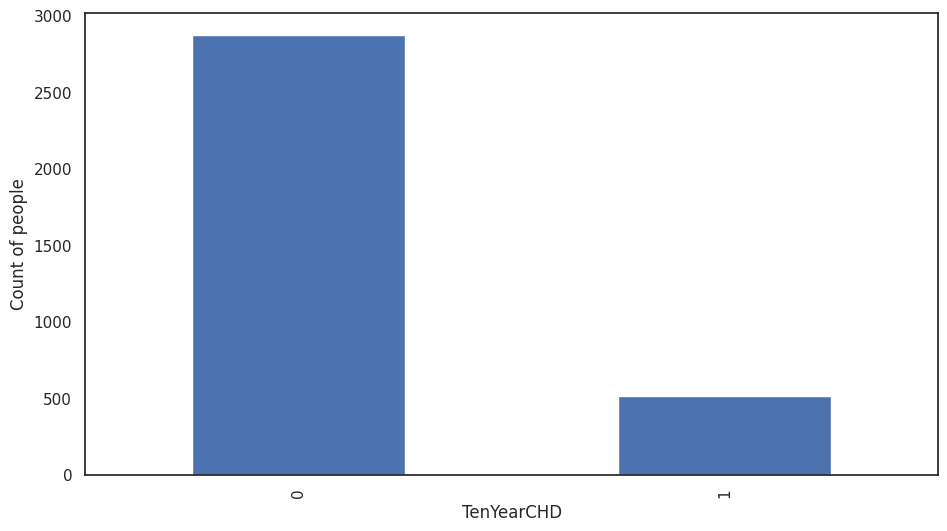

In [35]:
# Visualising the class balance BEFORE using SMOTE
plt.figure(figsize = (11, 6))
ax = Y_train.value_counts().plot(kind = 'bar')
plt.ylabel('Count of people')
plt.xlabel('TenYearCHD')

In [36]:
# Handling Imbalanced Dataset
smote = SMOTE(random_state = 8)
X_smote, Y_train_final = smote.fit_resample(X_train, Y_train)


Text(0.5, 0, 'TenYearCHD')

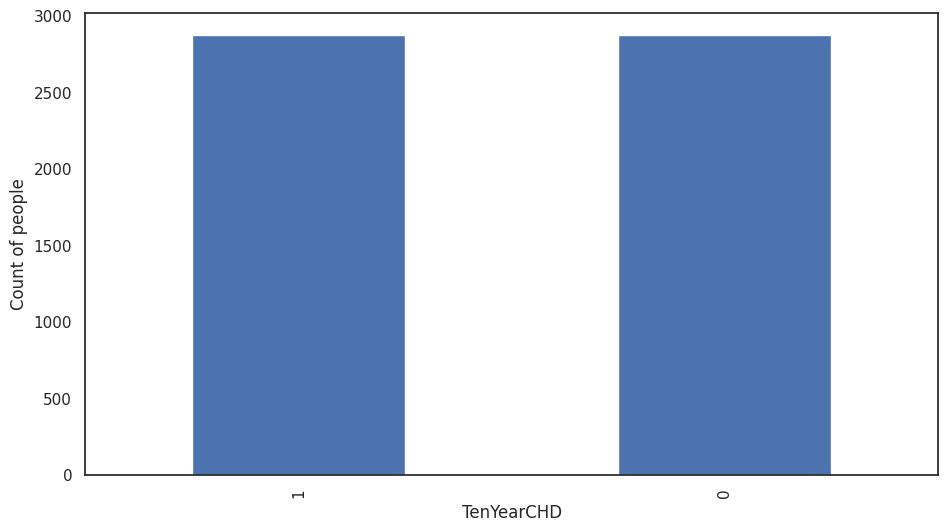

In [37]:
# Visualising the class balance AFTER using SMOTE
plt.figure(figsize = (11, 6))
ax = Y_train_final.value_counts().plot(kind = 'bar')
plt.ylabel('Count of people')
plt.xlabel('TenYearCHD')

Data scaling

In [38]:
# Scaling the train and test data according to train data
scaler = MinMaxScaler()
X_train_final = scaler.fit_transform(X_smote)
X_test_final = scaler.transform(X_test)

### Model Implementation

Functions to train each model and plot its results.

In [39]:
# Plot the Confusion Matrix
def confusion_plot(cm):
  '''Plots the Confusion Matrix given as input'''
  cmd = ConfusionMatrixDisplay(cm, display_labels = ['No risk (0)', 'Risk (1)'])
  cmd.plot(cmap = 'Blues')
  plt.title('Confusion Matrix for Test Data')
  plt.show()

# Function to train and test a given classification model
def model_train_test(model, train_x, train_y, test_x, test_y, gs = False, confusion = True):
  '''Trains the classification model given as input. Other inputs include Test and train data
  and a Boolean to inform the function if GridSearch is being performed
  Returns the train and test Recalls and ROC-AUC scores, the test data predictions, and the final model'''

  model.fit(train_x, train_y)
  if gs == True:
    print(f'Best model parameters are: {model.best_params_}')
    print(f'Best model score is: {model.best_score_}\n')
    model = model.best_estimator_

  # Getting the train and test predictions
  train_preds = model.predict(train_x)
  train_recall = recall_score(y_true = train_y, y_pred = train_preds, average='binary')
  train_roc = roc_auc_score(train_y, train_preds)
  test_preds = model.predict(test_x)
  test_recall = recall_score(y_true = test_y, y_pred = test_preds, average='binary')
  test_roc = roc_auc_score(test_y, test_preds)

  # Plotting confusion matrix
  if confusion == True:
    confusion_plot(confusion_matrix(test_y, test_preds))

  output_metrics = {'Train Recall':train_recall, 'Test Recall':test_recall, 'Train ROC-AUC':train_roc, 'Test ROC-AUC':test_roc}
  return output_metrics, test_preds, model

In [40]:
# Creating a dictionary of lists to store Train and test Recalls and ROC-AUC scores
scores = dict()
scores['Train Recall'] = []
scores['Test Recall'] = []
scores['Train ROC-AUC'] = []
scores['Test ROC-AUC'] = []
model_names = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'KNN', 'SVM', 'Random Forest', 'XGBoost']

#### Logistic regresion

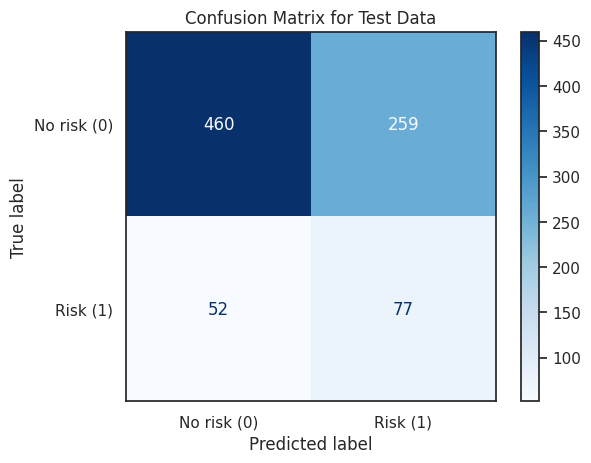

In [43]:
lr_scores, lr_test_preds, lr_model = model_train_test(LogisticRegression(), X_train_final, Y_train_final, X_test_final, Y_test)


In [44]:
print(classification_report(Y_test, lr_test_preds, target_names=['class-0', 'class-1']))


              precision    recall  f1-score   support

     class-0       0.90      0.64      0.75       719
     class-1       0.23      0.60      0.33       129

    accuracy                           0.63       848
   macro avg       0.56      0.62      0.54       848
weighted avg       0.80      0.63      0.68       848



In [45]:
def print_scores(model_name, model_scores):
  '''Function to print the scores of a given model'''
  print(f"The train and test recalls of the {model_name} Model are: {round(model_scores['Train Recall'] * 100, 2)}% and {round(model_scores['Test Recall'] * 100, 2)}% respectively")
  print(f"The train and test ROC-AUC scores of the {model_name} Model are: {round(model_scores['Train ROC-AUC'] * 100, 2)}% and {round(model_scores['Test ROC-AUC'] * 100, 2)}% respectively")

print_scores(model_name = model_names[0], model_scores = lr_scores)

The train and test recalls of the Logistic Regression Model are: 67.55% and 59.69% respectively
The train and test ROC-AUC scores of the Logistic Regression Model are: 66.45% and 61.83% respectively


[Text(0.5, 0, 'Features'), Text(0, 0.5, 'Feature importances')]

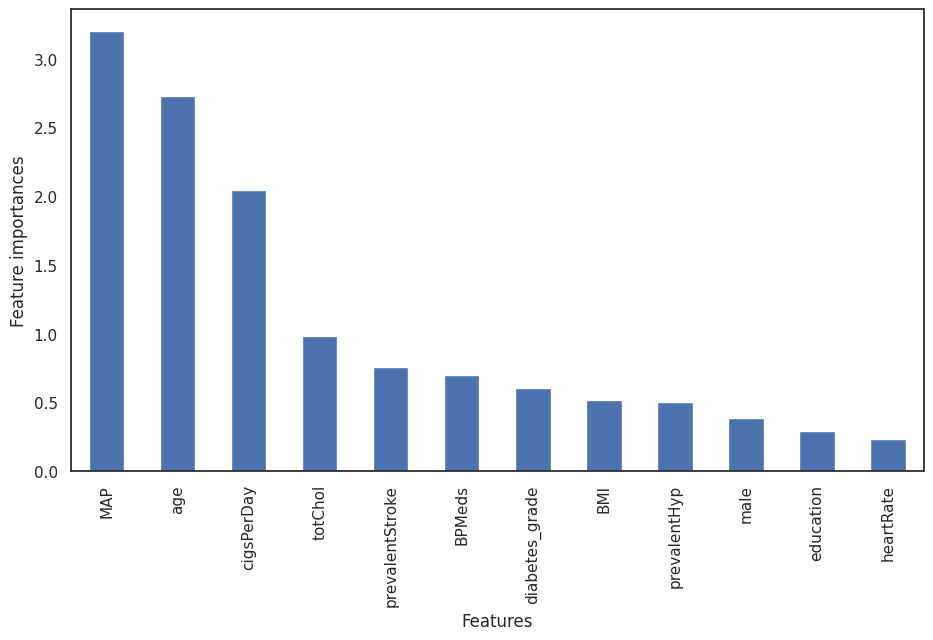

In [46]:
lr_importances = pd.Series(abs(lr_model.coef_[0]), index = X.columns)
plt.figure(figsize = (11, 6))
ax = lr_importances.sort_values(ascending = False).plot(kind = 'bar')
ax.set(xlabel = 'Features', ylabel = 'Feature importances')

append the scores to the dictionary

In [47]:
for score in lr_scores:
  scores[score].append(lr_scores[score] * 100)

#### Naive Bayes

search for hyperparameter tuning for the Gaussian Naive Bayes model (GaussianNB) using cross-validation (RepeatedStratifiedKFold) with a focus on optimizing the recall metric

In [53]:
params_nb = {'var_smoothing': np.logspace(0, -9, num = 50)}
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
scorer = make_scorer(recall_score, average = 'binary')

nb_models = GridSearchCV(GaussianNB(), params_nb, cv = cv, scoring = scorer)

Best model parameters are: {'var_smoothing': 2.559547922699533e-05}
Best model score is: 0.5587246376811594



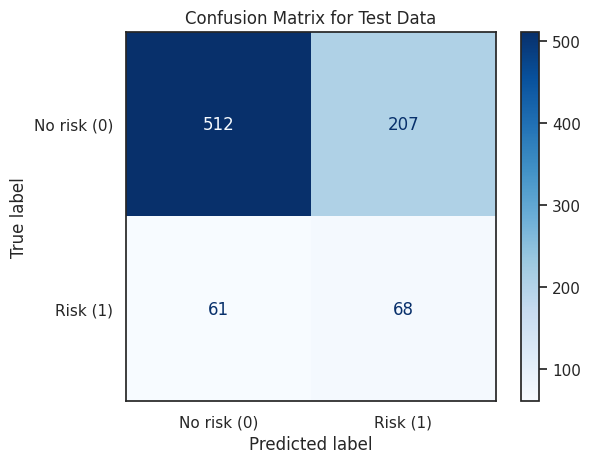

In [54]:
nb_scores, nb_test_preds, nb_model = model_train_test(nb_models, X_train_final, Y_train_final, X_test_final, Y_test, gs = True)


In [55]:
print(classification_report(Y_test, nb_test_preds, target_names=['class-0', 'class-1']))

              precision    recall  f1-score   support

     class-0       0.89      0.71      0.79       719
     class-1       0.25      0.53      0.34       129

    accuracy                           0.68       848
   macro avg       0.57      0.62      0.56       848
weighted avg       0.80      0.68      0.72       848



In [56]:
print_scores(model_name = model_names[1], model_scores = nb_scores)


The train and test recalls of the Naive Bayes Model are: 55.79% and 52.71% respectively
The train and test ROC-AUC scores of the Naive Bayes Model are: 62.38% and 61.96% respectively


In [57]:
for score in nb_scores:
  scores[score].append(nb_scores[score] * 100)

### Decision tree

In [59]:
#specifying the hyperparameters to be tuned for the Decision Tree model.
params_dt = {
              'max_depth' : [3, 4, 5],
              'min_samples_split':[10, 20, 25, 30],
              'min_samples_leaf':[10, 20, 25, 30]
              }

dt_model = DecisionTreeClassifier(criterion= 'entropy', random_state = 42)
dt_models = GridSearchCV(dt_model, params_dt, cv = cv, scoring = scorer)


Best model parameters are: {'max_depth': 4, 'min_samples_leaf': 30, 'min_samples_split': 10}
Best model score is: 0.805913043478261



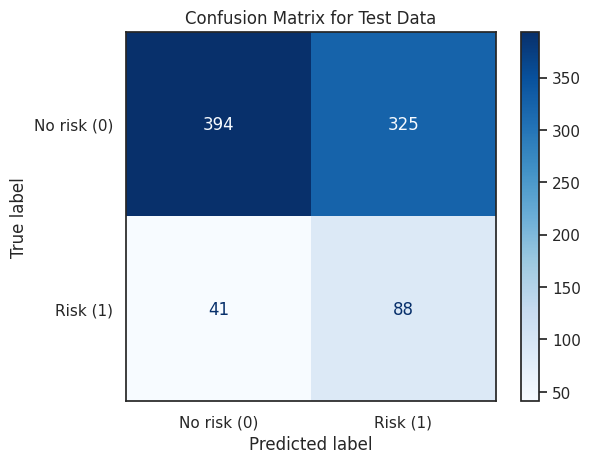

In [61]:
dt_scores, dt_test_preds, dt_model = model_train_test(dt_models, X_train_final, Y_train_final, X_test_final, Y_test, gs = True)


In [62]:
print(classification_report(Y_test, dt_test_preds, target_names=['class-0', 'class-1']))


              precision    recall  f1-score   support

     class-0       0.91      0.55      0.68       719
     class-1       0.21      0.68      0.32       129

    accuracy                           0.57       848
   macro avg       0.56      0.62      0.50       848
weighted avg       0.80      0.57      0.63       848



In [63]:
print_scores(model_name = model_names[2], model_scores = dt_scores)


The train and test recalls of the Decision Tree Model are: 78.75% and 68.22% respectively
The train and test ROC-AUC scores of the Decision Tree Model are: 67.13% and 61.51% respectively


[Text(0.5, 0, 'Features'), Text(0, 0.5, 'Feature importances')]

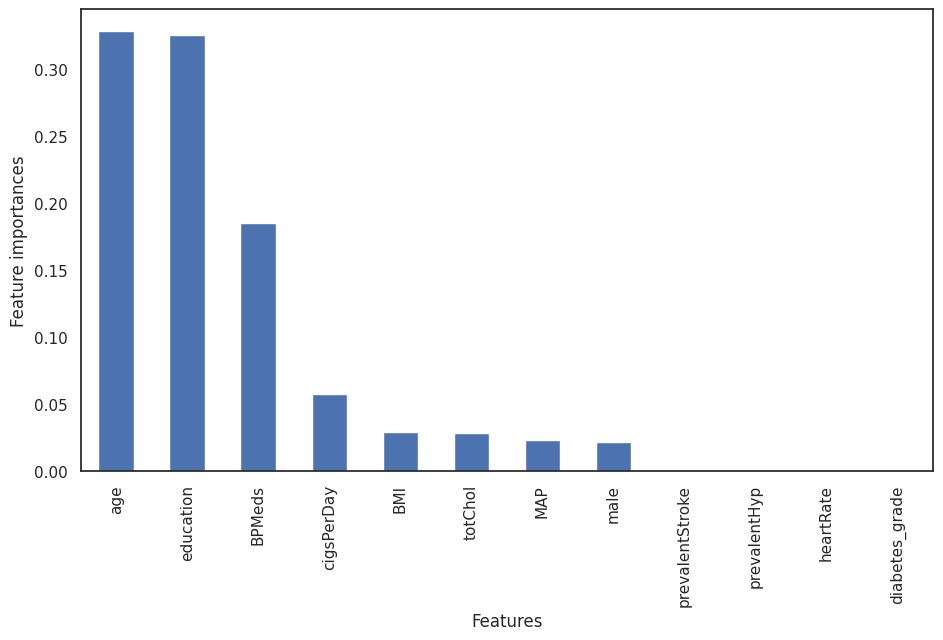

In [64]:
dt_importances = pd.Series(dt_model.feature_importances_, index = X.columns)
plt.figure(figsize = (11, 6))
ax = dt_importances.sort_values(ascending = False).plot(kind = 'bar')
ax.set(xlabel = 'Features', ylabel = 'Feature importances')

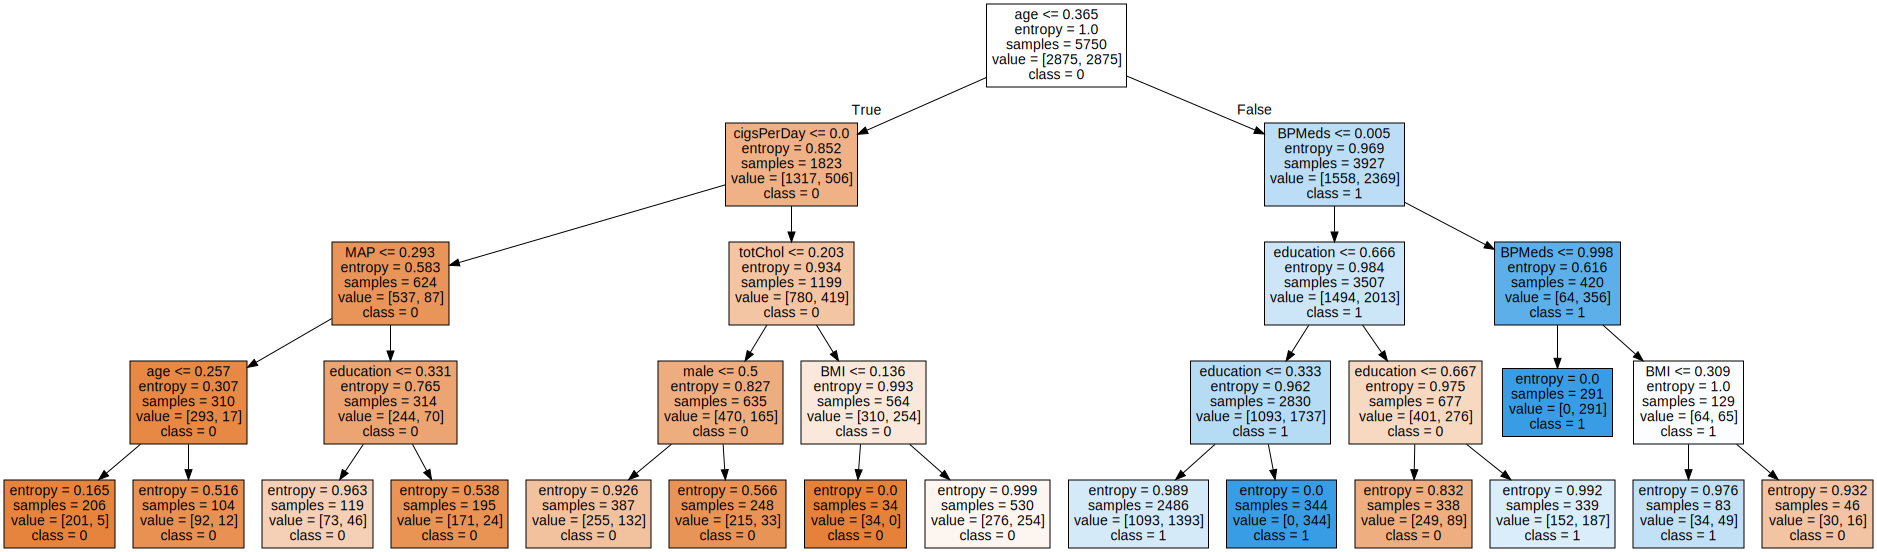

In [75]:
# Visualising the decision tree
graph = Source(tree.export_graphviz(dt_model, out_file = None, feature_names = X.columns, class_names=['0', '1'] , filled = True))
display(SVG(graph.pipe(format = 'svg')))

In [74]:
for score in dt_scores:
  scores[score].append(dt_scores[score] * 100)

#### KNN

In [84]:
# Fitting the knn model for various values of k
knn_train_recalls = []
knn_test_recalls = []
for k in range(1, 51):
  knn_scores = model_train_test(KNeighborsClassifier(n_neighbors = k), X_train_final, Y_train_final, X_test_final, Y_test, confusion = False)[0]
  knn_train_recalls.append(knn_scores['Train Recall'])
  knn_test_recalls.append(knn_scores['Test Recall'])

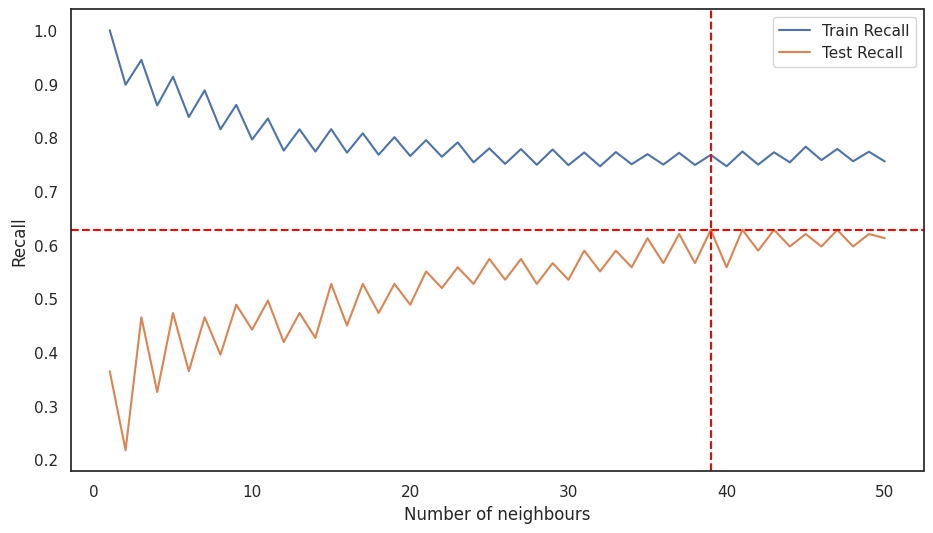

Optimum value of n_neighbours with highest value of test recall is 39


In [85]:
# Plotting the train and test recalls
k_optimum = knn_test_recalls.index(max(knn_test_recalls)) + 1
plt.figure(figsize=(11, 6))
plt.plot(range(1, 51), knn_train_recalls, label='Train Recall')
plt.plot(range(1, 51), knn_test_recalls, label='Test Recall')
plt.axhline(max(knn_test_recalls), color = 'red', linestyle = '--')
plt.axvline(k_optimum, color = 'red', linestyle = '--')
plt.xlabel('Number of neighbours')
plt.ylabel('Recall')
plt.legend()
plt.show()

print(f'Optimum value of n_neighbours with highest value of test recall is {k_optimum}')

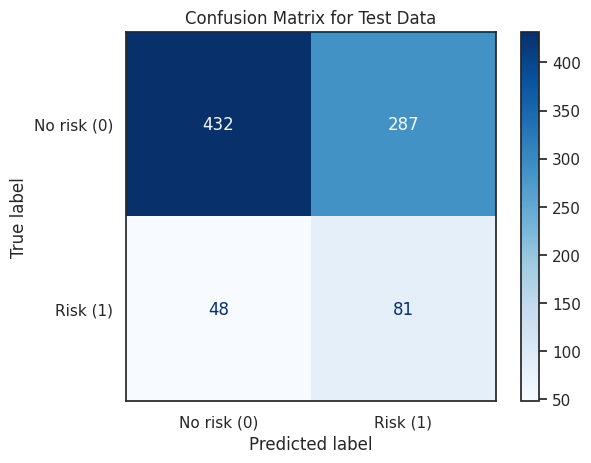

In [78]:
# Fitting the knn model with the optimum k
knn_scores, knn_test_preds, knn_model = model_train_test(KNeighborsClassifier(n_neighbors = k_optimum), X_train_final, Y_train_final, X_test_final, Y_test, gs = False)


In [79]:
print(classification_report(Y_test, knn_test_preds, target_names=['class-0', 'class-1']))


              precision    recall  f1-score   support

     class-0       0.90      0.60      0.72       719
     class-1       0.22      0.63      0.33       129

    accuracy                           0.60       848
   macro avg       0.56      0.61      0.52       848
weighted avg       0.80      0.60      0.66       848



In [80]:
print_scores(model_name = model_names[3], model_scores = knn_scores)


The train and test recalls of the KNN Model are: 76.77% and 62.79% respectively
The train and test ROC-AUC scores of the KNN Model are: 70.31% and 61.44% respectively


In [81]:
for score in knn_scores:
  scores[score].append(knn_scores[score] * 100)

### SVM

In [82]:
params_svc = {
              'C':[0.1, 1, 10],
              'gamma':[0.01, 0.001, 0.0001],
              'kernel':['rbf', 'poly', 'sigmoid']
              }

svc_models = GridSearchCV(SVC(), params_svc, cv = cv, scoring = scorer)

Best model parameters are: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best model score is: 0.7157101449275363



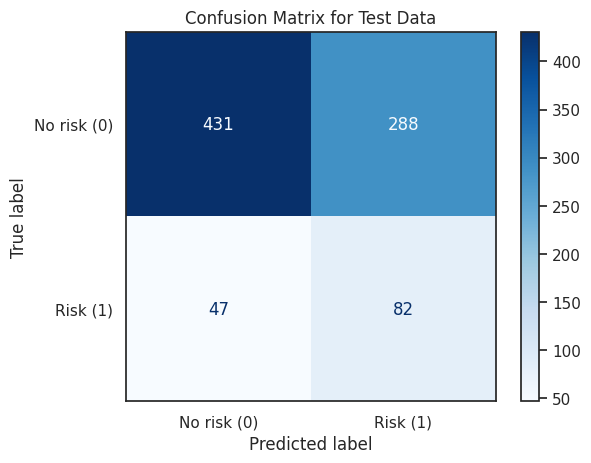

In [83]:
svc_scores, svc_test_preds, svc_model = model_train_test(svc_models, X_train_final, Y_train_final, X_test_final, Y_test, gs = True)


In [86]:
print(classification_report(Y_test, svc_test_preds, target_names=['class-0', 'class-1']))


              precision    recall  f1-score   support

     class-0       0.90      0.60      0.72       719
     class-1       0.22      0.64      0.33       129

    accuracy                           0.60       848
   macro avg       0.56      0.62      0.52       848
weighted avg       0.80      0.60      0.66       848



In [87]:
print_scores(model_name = model_names[4], model_scores = svc_scores)


The train and test recalls of the SVM Model are: 71.86% and 63.57% respectively
The train and test ROC-AUC scores of the SVM Model are: 66.9% and 61.76% respectively


In [88]:
for score in svc_scores:
  scores[score].append(svc_scores[score] * 100)

### Random forest

In [89]:
params_rf = {
              'n_estimators':[50, 100, 200],
              'max_depth':[3, 4, 5],
              'min_samples_split':[10, 20, 25],
              'min_samples_leaf':[10, 20, 25]
              }

rf_model = RandomForestClassifier(criterion= 'entropy', random_state = 42)
rf_models = GridSearchCV(rf_model, params_rf, cv = cv, scoring = scorer)

Best model parameters are: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 25, 'n_estimators': 100}
Best model score is: 0.8129855072463769



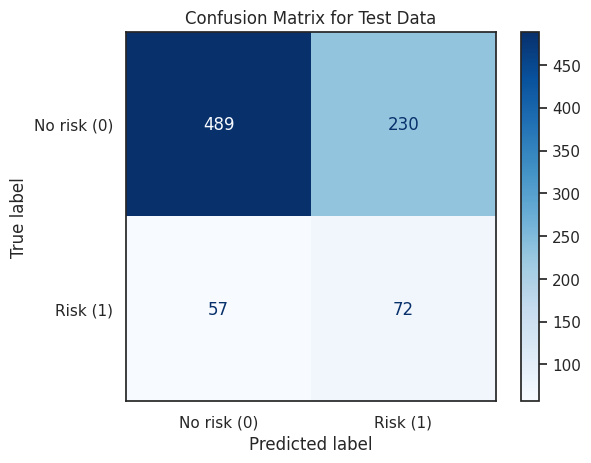

CPU times: user 8min 8s, sys: 1.17 s, total: 8min 9s
Wall time: 8min 14s


In [90]:
%%time
rf_scores, rf_test_preds, rf_model = model_train_test(rf_models, X_train_final, Y_train_final, X_test_final, Y_test, gs = True)

In [91]:
print(classification_report(Y_test, rf_test_preds, target_names=['class-0', 'class-1']))


              precision    recall  f1-score   support

     class-0       0.90      0.68      0.77       719
     class-1       0.24      0.56      0.33       129

    accuracy                           0.66       848
   macro avg       0.57      0.62      0.55       848
weighted avg       0.80      0.66      0.71       848



In [92]:
print_scores(model_name = model_names[5], model_scores = rf_scores)


The train and test recalls of the Random Forest Model are: 83.62% and 55.81% respectively
The train and test ROC-AUC scores of the Random Forest Model are: 76.66% and 61.91% respectively


[Text(0.5, 0, 'Features'), Text(0, 0.5, 'Feature importances')]

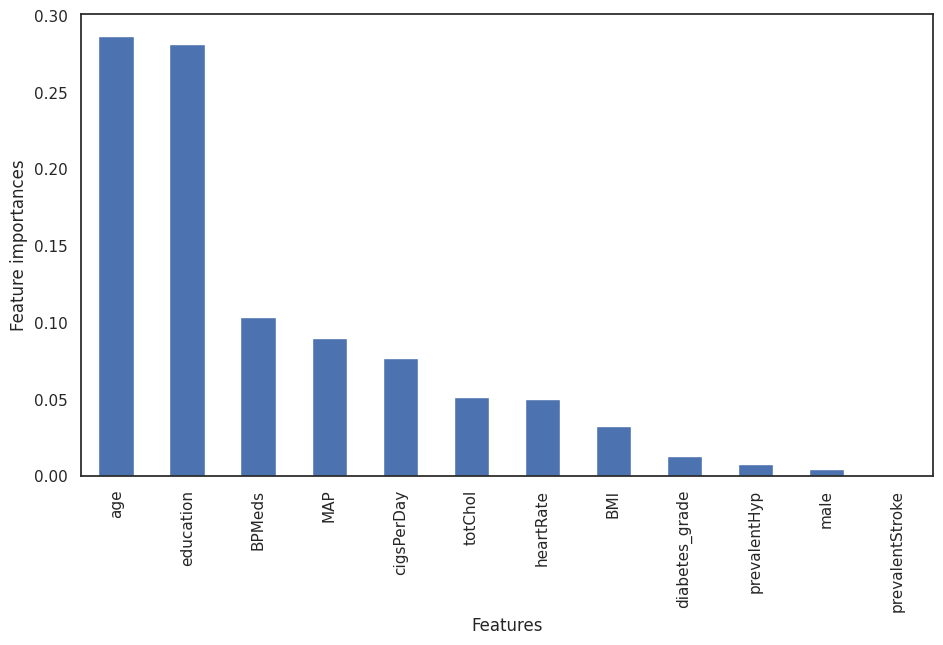

In [93]:
rf_importances = pd.Series(rf_model.feature_importances_, index = X.columns)
plt.figure(figsize = (11, 6))
ax = rf_importances.sort_values(ascending = False).plot(kind = 'bar')
ax.set(xlabel = 'Features', ylabel = 'Feature importances')

In [94]:

for score in rf_scores:
  scores[score].append(rf_scores[score] * 100)

XGBoost

In [97]:
params_xgb = {
              'n_estimators':[50, 100],
              'max_depth':[3, 4],
              'learning_rate':[0.01, 0.02]
              }

xgb_model = xgb.XGBClassifier(random_state = 42)
xgb_models = GridSearchCV(xgb_model, params_xgb, cv = cv, scoring = scorer)

Best model parameters are: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}
Best model score is: 0.8172753623188406



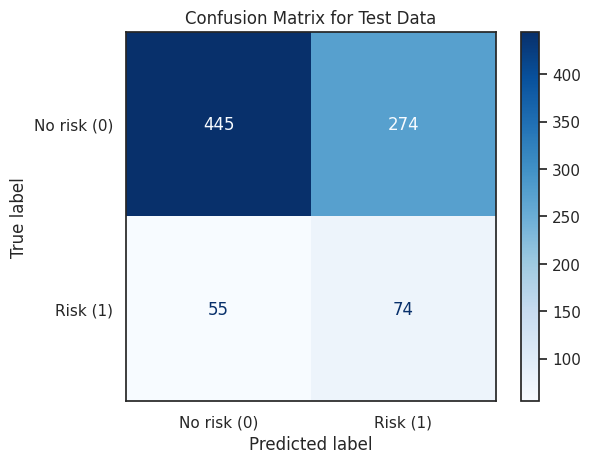

In [98]:
xgb_scores, xgb_test_preds, xgb_model = model_train_test(xgb_models, X_train_final, Y_train_final, X_test_final, Y_test, gs = True)


In [99]:
print(classification_report(Y_test, xgb_test_preds, target_names=['class-0', 'class-1']))


              precision    recall  f1-score   support

     class-0       0.89      0.62      0.73       719
     class-1       0.21      0.57      0.31       129

    accuracy                           0.61       848
   macro avg       0.55      0.60      0.52       848
weighted avg       0.79      0.61      0.67       848



In [100]:
print_scores(model_name = model_names[6], model_scores = xgb_scores)


The train and test recalls of the XGBoost Model are: 83.83% and 57.36% respectively
The train and test ROC-AUC scores of the XGBoost Model are: 73.77% and 59.63% respectively


[Text(0.5, 0, 'Features'), Text(0, 0.5, 'Feature importances')]

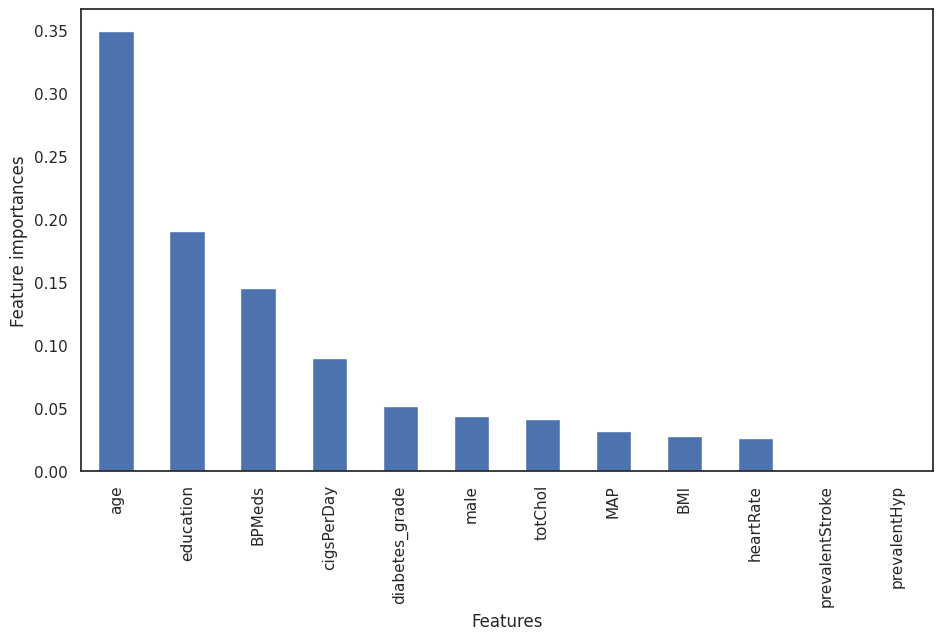

In [101]:
xgb_importances = pd.Series(xgb_model.feature_importances_, index = X.columns)
plt.figure(figsize = (11, 6))
ax = xgb_importances.sort_values(ascending = False).plot(kind = 'bar')
ax.set(xlabel = 'Features', ylabel = 'Feature importances')

In [102]:
for score in xgb_scores:
  scores[score].append(xgb_scores[score] * 100)

## Results

In [103]:
results_df = pd.DataFrame(scores, index = model_names)
styler_list = [
                {'selector': 'th','props': [('border', '2px solid black')]},
                {'selector': 'td','props': [('border', '2px solid black')]}
              ]
styler = results_df.style.set_table_styles(styler_list)
display(styler)

,Train Recall,Test Recall,Train ROC-AUC,Test ROC-AUC
Logistic Regression,67.547826,59.689922,66.452174,61.833835
Naive Bayes,55.791304,52.713178,62.382609,61.961596
Decision Tree,78.747826,68.217054,67.130435,61.507693
KNN,76.765217,62.790698,70.313043,61.437073
SVM,71.860870,63.565891,66.904348,61.755129
Random Forest,83.617391,55.813953,76.660870,61.912540
XGBoost,83.826087,57.364341,73.773913,59.627929


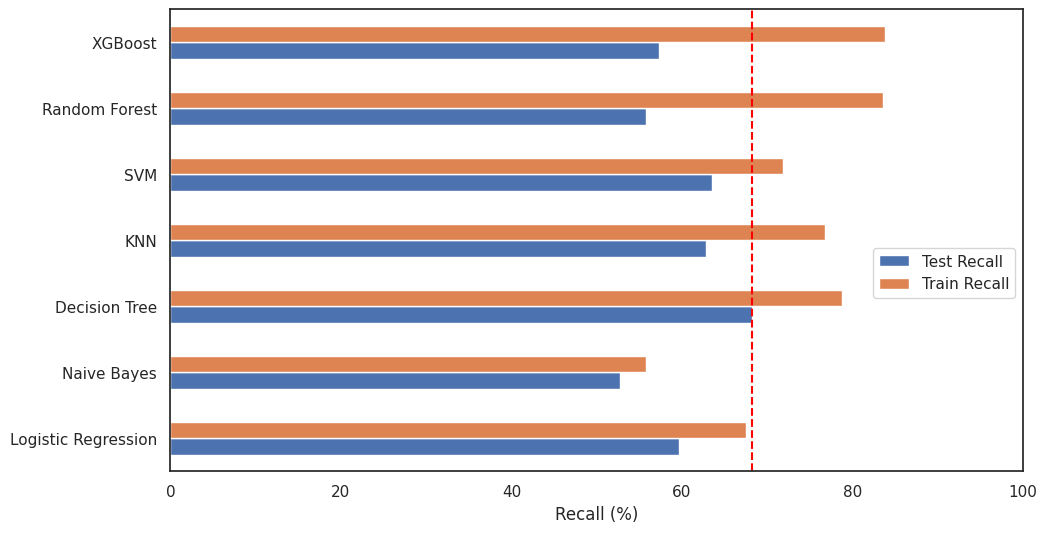

In [104]:
results_df[['Test Recall', 'Train Recall']].plot(kind = 'barh', figsize = (11, 6))
plt.xlabel('Recall (%)')
plt.xlim((0, 100))
plt.axvline(results_df['Test Recall'].max(), color = 'red', linestyle = '--')
plt.legend(bbox_to_anchor = (1, 0.5))
plt.show()

In this scenario, considering the balance between train and test performance, Decision Tree might be a reasonable choice due to its relatively good performance on both training and testing datasets, indicating less overfitting compared to other models like Random Forest and XGBoost.